In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [123]:

def get_meteo(url, months, year):
    all_data = []

    for month in months:
        params = {'mois': month, 'annee': year, 'sn': 0}
        response = requests.get(url, params=params)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find table and read into DataFrame
        table = soup.find('table', attrs={'cellpadding':2, 'style': 'border-collapse: collapse', 'border': '1'})
        df = pd.read_html(str(table), header=0)[0]
        
        # month e year colunas
        df['Mois'] = str(month).zfill(2)
        df['Année'] = str(year)
        all_data.append(df)

    # Concat tables
    df_temp = pd.concat(all_data, ignore_index=True)

    # Date colun
    df_temp['Jour'] = df_temp['Jour'].astype(str).str.extract(r'(\d+)')[0].str.zfill(2)
    df_temp['Date'] = pd.to_datetime(df_temp['Année'] + '-' + df_temp['Mois'] + '-' + df_temp['Jour'], errors='coerce')
    
    # Clean temp columns
    for col in ['Température max.', 'Température min.']:
        df_temp[col] = pd.to_numeric(df_temp[col].str.replace(' °C', '', regex=False).str.strip(), errors='coerce')


    return df_temp[['Date', 'Température max.', 'Température min.']]


url = "https://www.meteociel.fr/climatologie/obs_villes.php?code2=75107005"
df_meteo = get_meteo(url, range(1, 13), 2025)
df_meteo = df_meteo.rename(columns={"Date": "date"})
df_meteo.head()


/var/folders/0l/7gz9xwp549b_58gc1msglk5w00dt1p/T/ipykernel_10619/3801430412.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table), header=0)[0]
/var/folders/0l/7gz9xwp549b_58gc1msglk5w00dt1p/T/ipykernel_10619/3801430412.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table), header=0)[0]
/var/folders/0l/7gz9xwp549b_58gc1msglk5w00dt1p/T/ipykernel_10619/3801430412.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table), header=0)[0]
/var/folders/0l/7gz9xwp549b_58gc1msglk5w00dt1p/T/ipykernel_10619/3801430412.py:11: FutureWarning: Passing lit

,date,Température max.,Température min.
0,2025-01-01,6.8,2.2
1,2025-01-02,3.1,0.5
2,2025-01-03,2.7,0.2
3,2025-01-04,9.4,-1.9
4,2025-01-05,11.0,-1.1


In [110]:


URL = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/comptage-velo-donnees-compteurs/records"

def fetch_all_velo_data(batch_size=100):
    all_data = []
    offset = 0
    
    while True:
        params = {"limit": batch_size,"offset": offset }
        
        try:
            response = requests.get(URL, params=params, timeout=10)
            response.raise_for_status()
            data = response.json().get('results', [])
            
            if not data:
                break  # Não há mais registros
            
            all_data.extend(data)
            offset += batch_size
            
        except requests.RequestException as e:
            print(f"Error: {e}")
            break
    
    return all_data


velo_data = fetch_all_velo_data()
print(f"Total: {len(velo_data)}")




Error: 400 Client Error: Bad Request for url: https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/comptage-velo-donnees-compteurs/records?limit=100&offset=10000
Total: 10000


In [ ]:
#create dataframe
df_velo = pd.DataFrame(velo_data)

#drop columns
df_velo = df_velo.drop(columns=['url_photos_n1','photos','test_lien_vers_photos_du_site_de_comptage_', 
                       'url_sites', 
                       'type_dimage',
                      # 'nom_compteur', 
                       'name',
                        'id_photo_1'])


df_velo['date'] = pd.to_datetime(df_velo['date'], errors='coerce')


# remove the hour of the date
df_velo['date'] = df_velo['date'].dt.date

#group by compteur and day, summing counts
df_bike_daily = df_velo.groupby(['nom_compteur', 'date'])['sum_counts'].sum().reset_index()


print(df_bike_daily.head())


                        nom_compteur        date  sum_counts
0  18 quai de l'Hôtel de Ville NO-SE  2024-11-01         155
1  18 quai de l'Hôtel de Ville NO-SE  2024-11-02          93
2  18 quai de l'Hôtel de Ville NO-SE  2024-11-03         176
3  18 quai de l'Hôtel de Ville NO-SE  2024-11-04         300
4  18 quai de l'Hôtel de Ville NO-SE  2024-11-05         187


In [133]:
df_bike_daily["date"] = pd.to_datetime(df_bike_daily["date"], utc=True)#, errors="coerce")
df_meteo["date"] = pd.to_datetime(df_meteo["date"], utc=True)#, errors="coerce")

print(df_bike_daily["date"].min(), df_bike_daily["date"].max())
print(df_meteo["date"].min(), df_meteo["date"].max())

df_final = pd.merge(df_bike_daily, df_meteo, on="date", how="inner")
df_final.sample(10)
#df_meteo.head(10)

2024-11-01 00:00:00+00:00 2025-12-22 00:00:00+00:00
2025-01-01 00:00:00+00:00 2025-12-23 00:00:00+00:00


,nom_compteur,date,sum_counts,Température max.,Température min.
528,39 quai François Mauriac NO-SE,2025-06-23 00:00:00+00:00,1089,22.1,15.5
523,39 quai François Mauriac NO-SE,2025-06-18 00:00:00+00:00,1401,25.6,16.1
638,39 quai François Mauriac NO-SE,2025-10-11 00:00:00+00:00,830,15.6,9.6
540,39 quai François Mauriac NO-SE,2025-07-05 00:00:00+00:00,437,23.9,15.3
704,39 quai François Mauriac NO-SE,2025-12-16 00:00:00+00:00,420,13.3,9.6
287,18 quai de l'Hôtel de Ville NO-SE,2025-10-15 00:00:00+00:00,225,12.7,10.2
699,39 quai François Mauriac NO-SE,2025-12-11 00:00:00+00:00,840,8.8,6.0
35,18 quai de l'Hôtel de Ville NO-SE,2025-02-05 00:00:00+00:00,260,4.4,0.9
378,18 quai de l'Hôtel de Ville SE-NO,2025-01-23 00:00:00+00:00,267,6.8,2.9
47,18 quai de l'Hôtel de Ville NO-SE,2025-02-17 00:00:00+00:00,323,4.0,-1.7


<Axes: xlabel='Température max.', ylabel='sum_counts'>

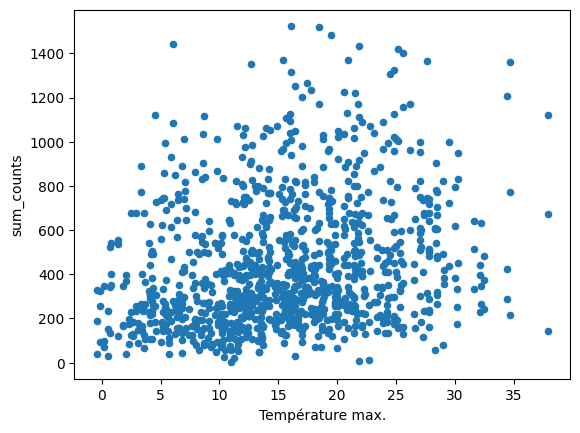

In [134]:
#plot 
df_final.plot(x="Température max.", y="sum_counts", kind="scatter")


In [135]:
import sqlite3

conn = sqlite3.connect("velo_meteo_paris.sqlite")

df_final.to_sql("velo_meteo", conn, if_exists="replace", index=False)

conn.close()
